In [56]:
%load_ext google.cloud.bigquery
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import pathlib
import pickle
import os
from typing import Union

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns

WORK_DIR = pathlib.Path.cwd()
DATA_DIR = WORK_DIR/'data/input'
OUT_DIR = WORK_DIR/'data/output'


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
train = pd.read_csv(DATA_DIR/'train.csv', nrows=200000)
asset_details = pd.read_csv(DATA_DIR/'asset_details.csv')    
asset_details.sort_values('Asset_ID')

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [58]:
from typing import List, Tuple

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def preprocess_data(
    df: pd.DataFrame, 
    return_delays: List[int] = [1, 2, 3, 4, 5, 10, 15]
    ): 
    df_processed = df.copy()
    
    df_processed.columns = [col.lower().replace(' ', '_') for col in df_processed.columns]
    df_processed = df_processed.assign(
        timestamp_min = df_processed.timestamp.astype('datetime64[s]')
    ).set_index('timestamp')
        
    df_out = pd.DataFrame()
    for asset_id in df_processed.asset_id.unique():
        data1 = df_processed.loc[df_processed.asset_id == asset_id, :]
        print(f'ID {asset_id} Missing Target: {data1.target.isna().mean()*100:.2f}%')

        for delay in return_delays: 
            data1[f'log_return_{delay}_period'] = log_return(data1.close, periods=delay).fillna(0)
        
        data1.target = data1.target.fillna(method='ffill')
        df_out = df_out.append(data1.reindex(range(data1.index[0],data1.index[-1]+60,60),method='bfill').reset_index())
        
        print(f'{data1.shape}')

    return df_out.fillna(0)


def plot_data_avalability(train_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(21, 10))
    
    asset_col = 'Asset_ID'
    target_col = 'Target'

    if 'asset_id' in train_df.columns: 
        asset_col = asset_col.lower()
        target_col = asset_col.lower()

    mask = (train_df[target_col].notna())
    ax.scatter(train_df[mask].timestamp, train_df[mask][asset_col], s=1, label='With Target')

    mask = (train_df[target_col].isna())
    ax.scatter(train_df[mask].timestamp, train_df[mask][asset_col], s=1, label='Missing Target')

    asset_list = asset_details.Asset_Name.values
    ax.set_yticks(np.arange(len(asset_list)))
    ax.set_yticklabels(asset_list)
    ax.legend()





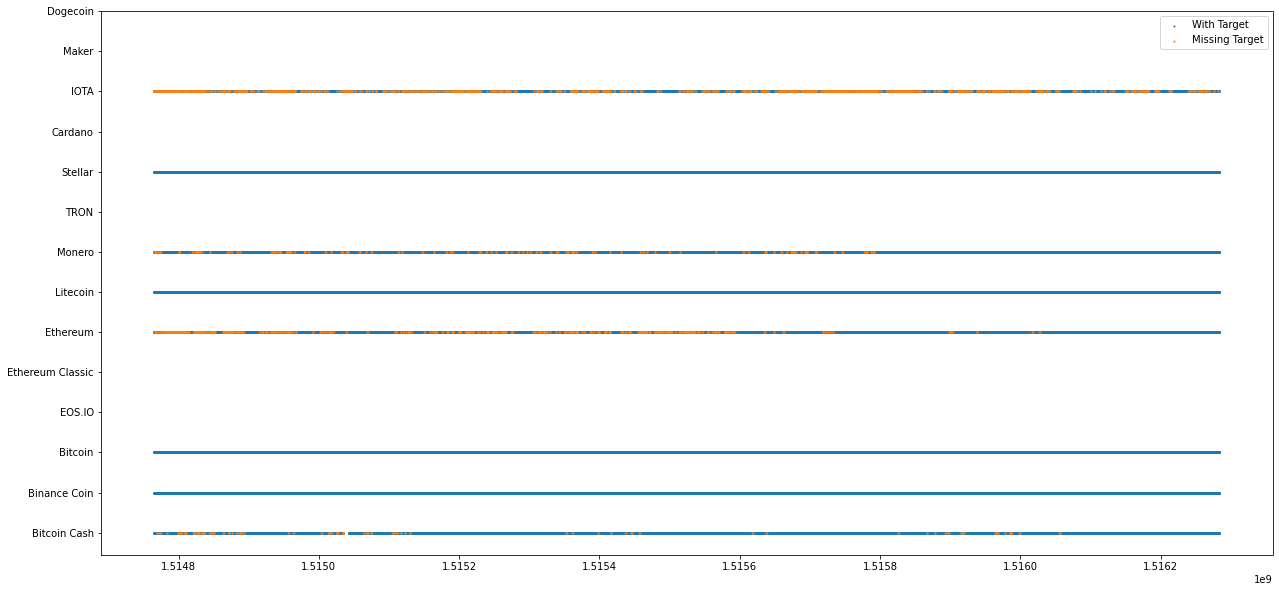

In [59]:
plot_data_avalability(train)

In [60]:
train_processed = preprocess_data(train)

ID 2 Missing Target: 0.00%
(25313, 17)
ID 0 Missing Target: 0.85%
(25078, 17)
ID 1 Missing Target: 0.00%


<ipython-input-58-9b1208ea6143>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\twongsan\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(25313, 17)
ID 5 Missing Target: 3.72%
(24780, 17)
ID 7 Missing Target: 1.12%
(25167, 17)
ID 6 Missing Target: 0.00%
(25313, 17)
ID 9 Missing Target: 0.00%
(25313, 17)
ID 11 Missing Target: 10.68%
(23723, 17)


In [61]:
train_processed.loc[train_processed.asset_id==2]

,timestamp,asset_id,count,open,high,low,close,volume,vwap,target,timestamp_min,log_return_1_period,log_return_2_period,log_return_3_period,log_return_4_period,log_return_5_period,log_return_10_period,log_return_15_period
0,1514764860,2,40.0,2376.580000,2399.5,2357.14,2374.590000,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1514764920,2,53.0,2374.553333,2400.9,2354.20,2372.286667,24.050259,2371.434498,-0.004079,2018-01-01 00:02:00,-0.000970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1514764980,2,61.0,2371.633333,2401.9,2353.70,2372.063333,42.676438,2375.442755,-0.002892,2018-01-01 00:03:00,-0.000094,-0.001065,0.000000,0.000000,0.000000,0.000000,0.000000
3,1514765040,2,95.0,2376.060000,2406.4,2344.00,2370.566667,37.820918,2371.096152,-0.003718,2018-01-01 00:04:00,-0.000631,-0.000725,-0.001696,0.000000,0.000000,0.000000,0.000000
4,1514765100,2,33.0,2372.656667,2404.6,2343.40,2370.173333,8.519679,2370.345730,-0.002171,2018-01-01 00:05:00,-0.000166,-0.000797,-0.000891,-0.001862,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25308,1516283340,2,161.0,1862.878000,1910.3,1799.00,1850.474000,62.587579,1856.786520,-0.000988,2018-01-18 13:49:00,-0.006963,-0.009385,-0.010140,-0.000408,-0.010886,-0.009574,-0.005570
25309,1516283400,2,83.0,1849.450000,1894.3,1798.04,1851.542000,56.731077,1850.245606,-0.005749,2018-01-18 13:50:00,0.000577,-0.006386,-0.008808,-0.009563,0.000169,-0.007500,-0.005062
25310,1516283460,2,69.0,1851.110000,1894.9,1799.98,1851.896000,53.189917,1852.146585,-0.003986,2018-01-18 13:51:00,0.000191,0.000768,-0.006195,-0.008617,-0.009372,-0.008653,-0.006480
25311,1516283520,2,69.0,1851.882000,1900.0,1794.56,1852.808000,26.133510,1852.581409,0.002620,2018-01-18 13:52:00,0.000492,0.000684,0.001261,-0.005703,-0.008124,-0.003158,-0.006010


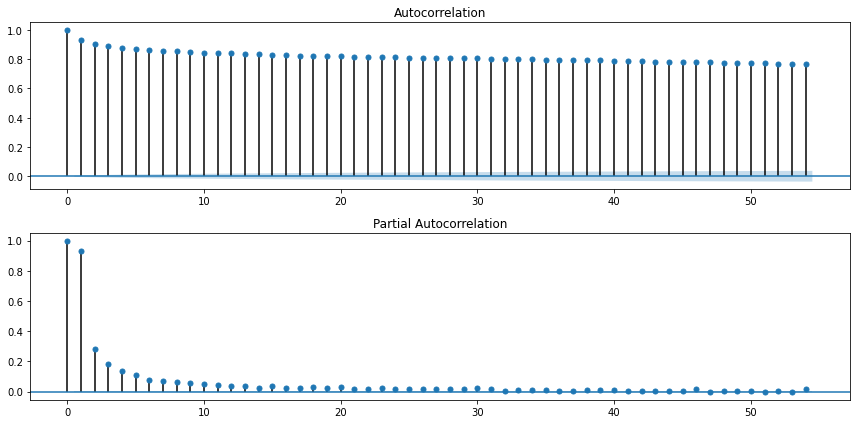

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(train_processed['count'], ax=ax1)
plot_pacf(train_processed['count'], ax=ax2)
plt.tight_layout()

In [63]:
import plotly.graph_objects as go

eth = train_processed.loc[train_processed.asset_id == 6].iloc[:100]
fig = go.Figure(data=[go.Candlestick(x=eth.index, open=eth['open'], high=eth['high'], low=eth['low'], close=eth['close'])])
fig.show()

## Sample Classical ML Model

In [64]:
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [65]:
num_col = ['count',	'open',	'high', 'low', 'close', 'volume', 'vwap'] + [col for col in train_processed.columns if 'return' in col]
cat_col = ['asset_id']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_col),
        ("cat", categorical_transformer, cat_col),
    ]
)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(train_processed.drop('target', axis=1), train_processed.target, random_state=123, test_size=0.1)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [67]:
xg_reg = XGBRegressor(random_state=123)
xg_reg.fit(X_train, y_train)

print(f'Train Corr: {np.corrcoef(xg_reg.predict(X_train), y_train)[0][1]:.4f}')
print(f'Test Corr: {np.corrcoef(xg_reg.predict(X_test), y_test)[0][1]:.4f}')

Train Corr: 0.5919
Train Corr: 0.1875


In [68]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(f'Train Corr: {np.corrcoef(lin_reg.predict(X_train), y_train)[0][1]:.4f}')
print(f'Test Corr: {np.corrcoef(lin_reg.predict(X_test), y_test)[0][1]:.4f}')

Train Corr: 0.0487
Train Corr: 0.0403


## NN Model

In [69]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model

In [ ]:
stock_embedding_size = 20
dense_layer_size = [32, 8]

cat_input = ['asset_id']
num_input = train_processed.columns.difference(['timestamp', 'timestamp_min', 'asset_id'])

def create_nn(
    stock_embedding_size = 20,
    dense_layer_size = [32, 16, 8],
    cat_input = cat_input,
    num_input =num_input
    ):
    cat_input_layer = keras.layers.Input(shape=(len(cat_input), ), name='cat_input')
    cat_embedded = keras.layers.Embedding(
        input_dim = len(train_processed[cat_input].unique())+1,
        output_dim = stock_embedding_size,  
        input_length=len(cat_input), 
        name='stock_embedding')(cat_input_layer)
    cat_embedded = keras.layers.Flatten()(cat_embedded)

    num_input_layer = keras.layers.Input(shape=(len(num_input),), name='num_input')
    num_norm= keras.layers.BatchNormalization()(num_input_layer)
    #num_dense = keras.layers.Dense(50, activation='selu')(num_input_layer)

    input_dense = keras.layers.Concatenate(axis=1)([cat_embedded, num_norm])
    input_dense = keras.layers.BatchNormalization()(input_dense)

    for size in dense_layer_size:
        input_dense = keras.layers.Dense(size, activation='selu')(input_dense)
        input_dense = keras.layers.BatchNormalization()(input_dense)

    output_layer = keras.layers.Dense(1, activation='linear', name='prediction')(input_dense)
    
    model = keras.Model(
    inputs = [cat_input_layer, num_input_layer], 
    outputs = output_layer
    )   
    